## Import

In [21]:
import momepy
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gpd

from tqdm import tqdm
from shapely import wkt
from typing import Optional
from shapely import LineString, Point, MultiPoint

import matplotlib.pyplot as plt

## Functions

### Загрузка GDF из OSM

In [2]:
def download_osm(id, tags=False):
    geocode_to_gdf = ox.geocode_to_gdf(id, by_osmid=True)
    polygon_boundary = geocode_to_gdf.unary_union
    if tags:
        gdf = ox.features_from_polygon(polygon_boundary, tags=tags)
    else:
        gdf = ox.features_from_polygon(polygon_boundary)
    return gdf

# tags = {'highway': ['motorway', 'trunk', 'primary', 
#                     'secondary','tertiary', 'unclassified', 
#                     'residential', 'motorway_link', 'trunk_link', 
#                     'primary_link', 'secondary_link', 'tertiary_link']}
# gdf_osm = download_osm(['R176095'], tags)

### Плотность УДС $км/км^2$

In [3]:
def density_roads(gdf_polygon: gpd.GeoDataFrame, gdf_line: gpd.GeoDataFrame, crs=3857) -> float:
    area = gdf_polygon.to_crs(epsg=crs).unary_union.area / 1000000
    length = gdf_line.to_crs(epsg=crs).geometry.length.sum()
    print(f'Плотность: {length / area:.3f} км/км^2')

    return round(length / area, 3)

### Протяженность дорог каждого типа

In [4]:
def calculate_length_sum_by_status(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf.to_crs(epsg=3857)
    gdf['REG_STATUS'] = gdf['REG_STATUS'].fillna(3)
    length_sum_by_status = gdf.groupby('REG_STATUS').geometry.apply(lambda x: x.length.sum() / 1000)
    print(length_sum_by_status.reset_index())
    
    return length_sum_by_status.reset_index()

### Перенос данных на дороги

In [ ]:
carcas = nx.read_graphml('data/graphml/GRAPH.graphml')
roads = gpd.read_file('data/geojsons/roads.geojson')

def add_attr(carcas, roads):

    def get_req(status,carcas,roads):
        carcas = nx.read_graphml('data/graphml/GRAPH.graphml')
        roads = gpd.read_file('data/geojsons/roads.geojson')
        for u, v, data in carcas.edges(data=True):
            data['geometry'] = wkt.loads(data['geometry'])

        
        roads['REG_STATUS'] = roads['REG_STATUS'].fillna(3)
        if status == -1:
            roads = roads
        else:
            roads = roads[roads['REG_STATUS']== status]


        part = ox.utils_graph.graph_to_gdfs(
            carcas, nodes=False, edges=True,
            node_geometry=False, fill_edge_geometry=True)
        part = part.reset_index(drop=True)

        attr = roads[roads['YEAR'].isna()].to_crs(part.crs)
        attr['new'] = 1

        def divide_line(row, num_parts):
            line = row.geometry
            length = line.length
            increment = length / (num_parts + 1)  # Divide line into (num_parts + 1) equal parts (including start and end points)
            points = [line.interpolate(i * increment) for i in range(1, num_parts + 1)]  # Exclude start and end points
            return MultiPoint([Point(point.coords[0]) for point in points])

        def unpack_multilinestrings_to_linestrings(gdf):
            rows_list = []
            for index, row in tqdm(gdf.iterrows()):
                geometry = row.points
                if isinstance(geometry, MultiPoint):
                    for linestring in geometry.geoms:
                        new_row = row.copy()
                        new_row.points = linestring
                        rows_list.append(new_row)
                else:
                    rows_list.append(row)
            new_gdf = gpd.GeoDataFrame(rows_list, columns=gdf.columns)
            return new_gdf

        part_extended = part.copy()
        part_extended['points'] = part_extended.apply(divide_line, axis=1,args=(5,)) # тут задаем разбиение на 5 точек
        part_extended.set_geometry('points',inplace=True)
        part_extended.crs = part.crs

        part_extended = unpack_multilinestrings_to_linestrings(part_extended)
        part_extended.set_geometry('points',inplace=True)
        part_extended.crs = part.crs

        point_neighbors = part_extended.sjoin_nearest(attr,distance_col = 'dist')


        filtered_point_neighbors = point_neighbors[point_neighbors['dist'] < 0.001]

        part['right_index'] = filtered_point_neighbors.groupby(filtered_point_neighbors.index)['index_right'].agg(lambda x: x.mode()[0])
        attr.reset_index(inplace=True)
        attr.rename(columns={'index': 'right_index'}, inplace=True)
        attr['right_index'] = attr['right_index'].astype(float)

        merged_df3 = pd.merge(part, attr, left_on='right_index', right_on='right_index', how='left')
        merged_df3 = merged_df3.set_geometry('geometry_x')

        merged_df3.loc[(merged_df3['REG_STATUS'] != 1) & (merged_df3['REG_STATUS'] != 2), 'REG_STATUS'] = 3.0

        merged_df3.drop(columns=['right_index','geometry_y'],inplace=True)
        merged_df3 = merged_df3.rename(columns={'geometry_x': 'geometry'})
        merged_df3 = merged_df3.rename(columns={'new': 'added_attr'})

        mask = merged_df3['added_attr'] != 1

        # List of columns to set to null
        columns_to_null = merged_df3.columns.difference(['added_attr', 'geometry'])

        # Set all columns (except 'name' and 'geometry') to null where 'new' is equal to 0
        merged_df3.loc[mask, columns_to_null] = np.nan

        merged_df3.set_geometry('geometry',inplace=True)

        return merged_df3

    reg1 = get_req(1,carcas,roads)
    reg2 = get_req(2,carcas,roads)
    reg3 = get_req(3,carcas,roads)

    
    reg2 = gpd.overlay(reg2, reg1, how='difference')

    reg12 = pd.concat([reg1, reg2], ignore_index=True)
    reg3 = gpd.overlay(reg3, reg12, how='difference')
    reg123 = pd.concat([reg12, reg3], ignore_index=True)

    return reg123

add_attr(carcas, roads)

## Work place

### Вроде, основная область

In [23]:
edges_spb = nx.read_graphml('data/graphml/GRAPH.graphml')
gdf_polygon = gpd.read_file('data/geojsons/Границы_только_МР_Границы_ЛО_Без_воды.geojson')
gdf_3000_points = gpd.read_file("data/geojsons/СНП ЛО.geojson")
roads = gpd.read_file('data/geojsons/roads.geojson')

In [6]:
def convert_node_names_to_int(graph):
    node_mapping = {node: int(node) for node in graph.nodes()}
    G_int = nx.relabel_nodes(graph, node_mapping)
    return G_int

def convert_geometry_to_wkt(graph):
    for _, _, data in graph.edges(data=True):
        geometry_wkt = wkt.loads(data['geometry'])
        data['geometry'] = geometry_wkt
    return graph

# использование функции:
edges_spb = convert_node_names_to_int(edges_spb)
edges_spb = convert_geometry_to_wkt(edges_spb)

In [7]:
nodes, edges = momepy.nx_to_gdf(edges_spb, points=True, lines=True, spatial_weights=False)
# edges = edges.to_crs(epsg=32636)

C:\Users\local\AppData\Local\Temp\ipykernel_14572\3433391287.py:1: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(edges_spb, points=True, lines=True, spatial_weights=False)


In [8]:
# Предпроцессинг типа
gdf_3000_points.to_crs(epsg=32636, inplace=True)
gdf_polygon.to_crs(epsg=32636, inplace=True)
# edges_spb.to_crs(epsg=32636, inplace=True)
# edges_spb['length'] = edges_spb.geometry.length

# Административные центры
cities = ["приозерск", "кировск", "кингисепп", "луга", 
          "лодейное поле", "гатчина", "тихвин", "тосно", 
          "выборг", "бокситогорск", "всеволожск", "волосово", 
          "волхов", "сосновый бор", "сланцы", "подпорожье", "кириши"]
cities_lower = [city.lower() for city in cities]

# Выделение административных центров
gdf_17_points = gdf_3000_points[
    (gdf_3000_points['name'].str.lower().isin(cities_lower)) &
    (gdf_3000_points['rural settlement'].str.contains('административный центр'))
].sort_values('name')

# 'how' определяет тип пространственного объединения: 'inner' означает, что в результат попадут только те объекты, которые пересекаются.
# 'predicate' определяет тип пространственного отношения: 'intersects', 'within', 'contains' и т.д.
# roads_within_polygon = gpd.sjoin(edges_spb, gdf_polygon, how='inner', predicate='intersects')

In [102]:
gdf_polygon.explore()
gdf_17_points.explore()

In [29]:
density = density_roads(gdf_polygon, edges)
# length_roads = calculate_length_sum_by_status(edges)

Плотность: 519.868 км/км^2


In [9]:
def transferring_points_on_line(
        gdf_points: gpd.GeoDataFrame, 
        gdf_lines:  gpd.GeoDataFrame,
        column_1:   Optional[str],
        column_2:   Optional[str]
        ) -> gpd.GeoDataFrame:
    
    gdf_points_copy = gdf_points.copy().reset_index(drop=True)
    gdf_lines_copy  = gdf_lines.copy().reset_index(drop=True)
    nearest_roads = gpd.sjoin_nearest(gdf_points_copy, gdf_lines_copy, how='left')
    if f'{column_1}_right' in nearest_roads.columns.values:
        gdf_lines_copy.loc[nearest_roads.index_right, column_2] = nearest_roads[f'{column_1}_left'].values
        return gdf_lines_copy
    else:
        gdf_lines_copy.loc[nearest_roads.index_right, column_2] = nearest_roads[column_1].values
        return gdf_lines_copy

gdf_lines = transferring_points_on_line(gdf_17_points, edges, column_1='name', column_2='admin_centers')

In [10]:
gdf_lines_copy = gdf_lines.copy()
# reg_status = gdf_lines_copy[['name', 'REG_STATUS', 'geometry', 'admin_centers']][gdf_lines_copy.REG_STATUS == 1].copy().reset_index()
# admin_centers = gdf_lines_copy[['name', 'REG_STATUS','geometry', 'admin_centers']][(gdf_lines_copy.admin_centers.notna())].copy()
admin_centers = gdf_lines_copy[['geometry', 'admin_centers']][(gdf_lines_copy.admin_centers.notna())].copy()

In [ ]:
buffer_for_city = {
    'Луга':             5000,
    'Волосово':         45000,
    'Сосновый бор':     55000,
    'Приозерск':        3000,
    'Гатчина':          10000,
    'Кировск':          2000,
    'Всеволожск':       25000,
    'Тосно':            1000,
    'Кириши':           100000,
    'Волхов':           20000,
    'Лодейное Поле':    5000,
    'Тихвин':           9000,
    'Бокситогорск':     30000,
    'Подпорожье':       80000,
    'Кингисепп':        5000,
    'Выборг':           8000,
    'Сланцы':           100000
}

# Инициализируйте словарь для хранения сопоставления id дороги и города
road_to_city_mapping = {}

for index, city in admin_centers.iterrows():
    # Создаем буфер вокруг каждого города
    buffer_meter = buffer_for_city[city['admin_centers']]
    buffer = city['geometry'].buffer(buffer_meter)
    roads_in_buffer = reg_status.loc[reg_status.geometry.intersects(buffer)]
    
    for road_id in roads_in_buffer['index']:
        # Если id дороги уже есть в словаре - добавить город к списку городов для этой id
        if road_id in road_to_city_mapping:
            road_to_city_mapping[road_id].append(city['admin_centers'])
        else:  # Если id дороги еще нет в словаре, создайте новый список городов с этим городом
            road_to_city_mapping[road_id] = [city['admin_centers']]
gdf_lines_copy['nearest_city'] = gdf_lines_copy.index.map(road_to_city_mapping)

In [ ]:
graph = momepy.gdf_to_nx(gdf_lines_copy.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if graph.nodes[u].get('REG_STATUS') != 1:
            graph.nodes[u]['REG_STATUS'] = data['REG_STATUS']
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_city'], list) and data['REG_STATUS'] == 1:
            if 'nearest_city' not in graph.nodes[u]:
                graph.nodes[u]['nearest_city'] = data['nearest_city']
                

    if graph.nodes[v]:
        if graph.nodes[v].get('REG_STATUS') != 1:
            graph.nodes[v]['REG_STATUS'] = data['REG_STATUS']
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_city'], list) and data['REG_STATUS'] == 1:
            if 'nearest_city' not in graph.nodes[v]:
                graph.nodes[v]['nearest_city'] = data['nearest_city']

In [ ]:
def search_min_distance(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            source_nodes.append((node, data['admin_centers']))
        if data.get('REG_STATUS') == 1 and isinstance(data.get('nearest_city'), list):  # Целевые узлы
            target_nodes.append((node, data['nearest_city']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            if graph.nodes[target_node].get('nearest_city') and name in graph.nodes[target_node]['nearest_city']:
                try: 
                    length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='length')
                    if name not in min_distances or (length/1000) < min_distances[name][0]:
                        min_distances[name] = (length/1000, path)
                except nx.NetworkXNoPath:
                    print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length = search_min_distance(graph)

In [ ]:
result_path_length.sort_values('min_distance')

In [ ]:
import folium
mymap = folium.Map()

edges = [(u,v,d) for u, v, d in graph.edges(data=True) if d['REG_STATUS'] == 1]

# Отображение на карте
for edge in edges:
    coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                   [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
    folium.PolyLine(coordinates, color="blue", weight=2.5, opacity=1, tooltip=f"{graph.nodes[edge[0]]['REG_STATUS']}").add_to(mymap)


for index_city in range(len(result_path_length['path'])):
    for i in range(len(result_path_length['path'][index_city]) - 1):
        edge = (result_path_length['path'][index_city][i], result_path_length['path'][index_city][i+1])
        if i == 0:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                        [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="yellow", weight=2.5, opacity=1).add_to(mymap)
        else:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                    [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="red", weight=2.5, opacity=1).add_to(mymap)

mymap

In [57]:
saint_petersburg_point = ox.geocode_to_gdf('N27490597', by_osmid=True)
saint_petersburg_point.to_crs(epsg=32636, inplace=True)
# edges_spb.to_crs(epsg=32636, inplace=True)
# edges_spb['length'] = edges_spb.geometry.length

In [58]:
gdf_18_points = pd.concat([gdf_17_points.to_crs(epsg=32636), saint_petersburg_point[['name', 'geometry']]], ignore_index=True)
# gdf_lines = transferring_points_on_line(gdf_18_points, roads_within_polygon.drop(columns=['index_right', 'name']), 'name')
gdf_lines_spb = transferring_points_on_line(gdf_18_points, edges, column_1='name', column_2='admin_centers')

In [125]:
gdf_lines_spb

,length_meter,geometry,type,time_min,highway,maxspeed,node_start,node_end,admin_centers
0,40.228689984528586,"LINESTRING (310156.237 6481909.657, 310165.823...",car,1.6091475993811435,trunk,90.0,0,1,NaN
1,7334.898281602861,"LINESTRING (310175.930 6481944.735, 310440.678...",car,293.39593126411444,trunk,90.0,1,674,NaN
2,40.228689984528586,"LINESTRING (310175.930 6481944.735, 310165.823...",car,1.6091475993811435,trunk,90.0,1,0,NaN
3,158.79071712315857,"LINESTRING (316822.012 6514139.318, 316864.213...",car,9.527443027389513,tertiary,60.0,2,3,NaN
4,209.10414346506604,"LINESTRING (316822.012 6514139.318, 316878.621...",car,12.546248607903962,tertiary,60.0,2,4,NaN
...,...,...,...,...,...,...,...,...,...
280143,42.97505911862326,"LINESTRING (222429.409 6727810.800, 222434.555...",car,2.5785035471173954,unclassified,60.0,112104,112105,NaN
280144,443.4615003320598,"LINESTRING (222453.684 6727777.907, 222478.142...",car,26.607690019923588,unclassified,60.0,112105,112105,NaN
280145,443.46150033205987,"LINESTRING (222453.684 6727777.907, 222468.710...",car,26.60769001992359,unclassified,60.0,112105,112105,NaN
280146,42.97505911862326,"LINESTRING (222453.684 6727777.907, 222434.555...",car,2.5785035471173954,unclassified,60.0,112105,112104,NaN


In [129]:
graph = momepy.gdf_to_nx(gdf_lines_spb.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
                
    if graph.nodes[v]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
    data['length_meter'] = float(data['length_meter'])

d:\IT\GitHub\ITMO_NCCR\.venv\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [130]:
list(graph.edges(data=True))[0]

((29.747796800006224, 58.43657340000325),
 (29.74810449999597, 58.43689649999675),
 {'length_meter': 40.228689984528586,
  'geometry': <LINESTRING (29.748 58.437, 29.748 58.437, 29.748 58.437)>,
  'type': 'car',
  'time_min': '1.6091475993811435',
  'highway': 'trunk',
  'maxspeed': '90.0',
  'node_start': 0,
  'node_end': 1,
  'admin_centers': nan,
  'mm_len': 0.00044617593345856917})

In [135]:
def search_min_distance_18(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            if data['admin_centers'] != 'Saint Petersburg':
                source_nodes.append((node, data['admin_centers']))
            elif data['admin_centers'] == 'Saint Petersburg':  # Целевые узлы
                target_nodes.append((node, data['admin_centers']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            try: 
                length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='length_meter')
                if name not in min_distances or (length/1000) < min_distances[name][0]:
                    min_distances[name] = (length/1000, path)
            except nx.NetworkXNoPath:
                print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length_18 = search_min_distance_18(graph)

100%|██████████| 68/68 [00:32<00:00,  2.10it/s]


In [136]:
# Объединение DataFrame
result_path_length_18.reset_index(inplace=True)
merged = pd.merge(
    gdf_18_points, 
    result_path_length_18, 
    left_on=['name'], 
    right_on=['index'], 
    how='left'
)

merged_full = pd.merge(
    gdf_polygon[['name', 'geometry']], 
    merged, 
    left_on=['name'], 
    right_on=['municipal district'], 
    how='left'
)

# Преобразование в GeoDataFrame
gdf_merged_full = gpd.GeoDataFrame(merged_full, geometry='geometry_x')

# Установка координатной системы
gdf_merged_full.crs = gdf_polygon.crs

In [137]:
gdf_merged_full

,name_x,geometry_x,index_x,municipal district,municipality,name_y,rural settlement,fid,centre,geometry_y,index_y,min_distance,path
0,Бокситогорский муниципальный район,"MULTIPOLYGON (((34.32834 59.19564, 34.32777 59...",0.0,Бокситогорский муниципальный район,Бокситогорское городское поселение,Бокситогорск,город (административный центр),None,административный центр,POINT (548021.065 6593118.772),Бокситогорск,249.778712,"[(33.84763959999498, 59.47388709999943), (33.8..."
1,Кингисеппский муниципальный район,"MULTIPOLYGON (((26.67752 59.96863, 26.67743 59...",6.0,Кингисеппский муниципальный район,Кингисеппское городское поселение,Кингисепп,город (административный центр),None,административный центр,POINT (250173.316 6590408.505),Кингисепп,127.061303,"[(28.605727999993956, 59.37604880000151), (28...."
2,Киришский муниципальный район,"MULTIPOLYGON (((31.94177 59.42479, 31.94327 59...",7.0,Киришский муниципальный район,Киришское городское поселение,Кириши,город (административный центр),None,административный центр,POINT (443794.163 6590546.292),Кириши,143.322301,"[(32.0096432999954, 59.450319400000836), (32.0..."
3,Кировский муниципальный район,"MULTIPOLYGON (((31.91715 59.95987, 31.91722 59...",8.0,Кировский муниципальный район,Кировское городское поселение,Кировск,город (административный центр),None,административный центр,POINT (386998.605 6639249.059),Кировск,47.907537,"[(30.981783299997147, 59.87539000000307), (30...."
4,Лодейнопольский муниципальный район,"MULTIPOLYGON (((32.95801 60.71431, 33.02438 60...",9.0,Лодейнопольский муниципальный район,Лодейнопольское городское поселение,Лодейное Поле,город (административный центр),None,административный центр,POINT (529770.526 6733344.297),Лодейное Поле,228.458745,"[(33.543354999995515, 60.73431620000092), (33...."
5,Ломоносовский муниципальный район,"MULTIPOLYGON (((28.84956 59.78505, 28.84950 59...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
6,Подпорожский муниципальный район,"MULTIPOLYGON (((35.52906 60.91530, 35.52806 60...",11.0,Подпорожский муниципальный район,Подпорожское городское поселение,Подпорожье,город (административный центр),None,административный центр,POINT (563284.880 6753632.930),Подпорожье,271.522374,"[(34.16488310000381, 60.91260160000349), (34.1..."
7,Приозерский муниципальный район,"MULTIPOLYGON (((30.69201 60.50326, 30.68940 60...",12.0,Приозерский муниципальный район,Приозерское городское поселение,Приозерск,город (административный центр),None,административный центр,POINT (344214.707 6770325.372),Приозерск,143.259219,"[(30.11604470000811, 61.03699219999634), (30.1..."
8,Сосновоборский городской округ,"MULTIPOLYGON (((28.97562 59.81609, 28.97583 59...",14.0,Сосновоборский городской округ,Сосновоборский городской округ,Сосновый бор,город (административный центр),None,административный центр,POINT (281442.400 6647388.065),Сосновый бор,87.924509,"[(29.088668700001673, 59.905479899999), (29.09..."
9,Волосовский муниципальный район,"MULTIPOLYGON (((28.98894 59.48069, 28.98604 59...",1.0,Волосовский муниципальный район,Волосовское городское поселение,Волосово,город (административный центр),None,административный центр,POINT (300642.217 6595175.345),Волосово,79.873759,"[(29.484855800005366, 59.447896200003946), (29..."


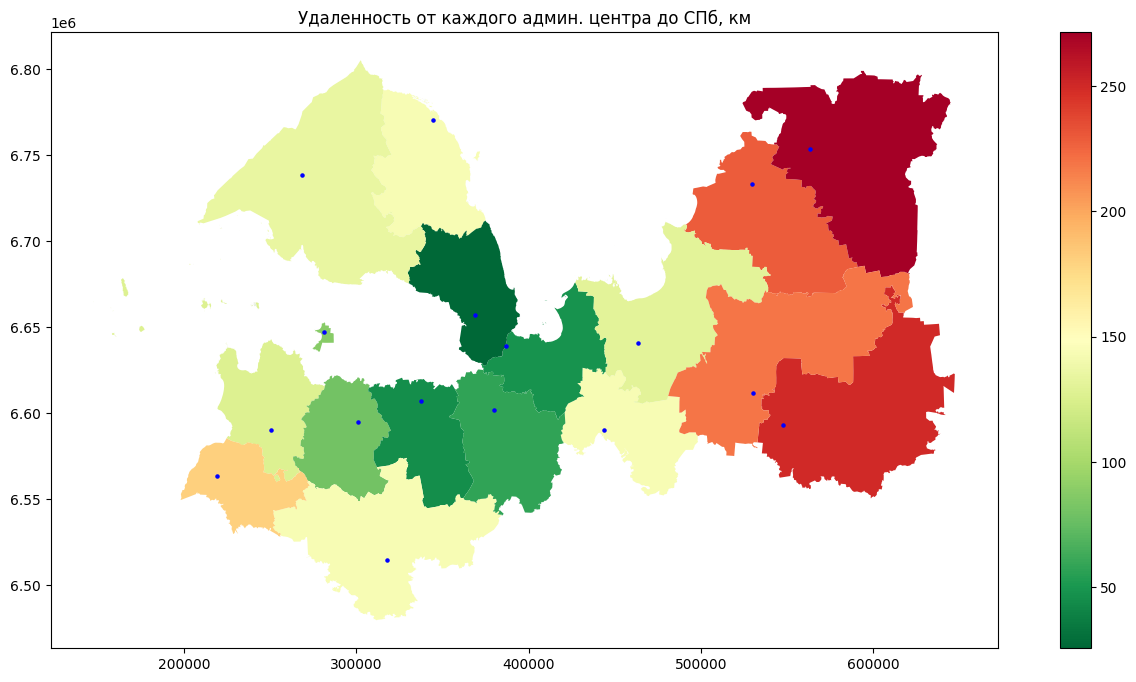

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Отображение полигонов с цветами, зависящими от столбца 'min_distance'
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True)
# Отображение точек
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5)
# Добавление легенды
plt.title('Удаленность от каждого админ. центра до СПб, км')
# Сохранение картинки
plt.savefig('data/png/Удаленность от каждого админ. центра до СПб, км.png', dpi=600)
# Отображение карты
plt.show()

In [ ]:
import folium
mymap = folium.Map()

for index_city in range(len(result_path_length_18['path'])):
    for i in range(len(result_path_length_18['path'][index_city]) - 1):
        edge = (result_path_length_18['path'][index_city][i], result_path_length_18['path'][index_city][i+1])
        if i == 0:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                        [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="yellow", weight=2.5, opacity=1).add_to(mymap)
        else:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                    [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="red", weight=2.5, opacity=1).add_to(mymap)

mymap

### Тестовая область

In [29]:
fuel_gdf = gpd.read_file('data/geojsons/fuel.geojson').to_crs(epsg=32636)
stops_gdf = gpd.read_file('data/geojsons/ЖД остановки.geojson').to_crs(epsg=32636)

In [30]:
gdf_lines_copy = gdf_lines.copy()
gdf_lines_fuel = transferring_points_on_line(fuel_gdf, gdf_lines_copy, column_1='name', column_2='fuel')

In [31]:
buffer_for_city = {
    'Луга':             20000,
    'Волосово':         20000,
    'Сосновый бор':     20000,
    'Приозерск':        20000,
    'Гатчина':          20000,
    'Кировск':          20000,
    'Всеволожск':       20000,
    'Тосно':            20000,
    'Кириши':           20000,
    'Волхов':           20000,
    'Лодейное Поле':    20000,
    'Тихвин':           20000,
    'Бокситогорск':     40000,
    'Подпорожье':       20000,
    'Кингисепп':        20000,
    'Выборг':           20000,
    'Сланцы':           20000
}



In [32]:
# Инициализируйте словарь для хранения сопоставления id дороги и города
road_to_city_mapping = {}

for index, city in admin_centers.iterrows():
    # Создаем буфер вокруг каждого города
    buffer_meter = buffer_for_city[city['admin_centers']]
    buffer = city['geometry'].buffer(buffer_meter)
    roads_in_buffer = gdf_lines_fuel.loc[gdf_lines_fuel[gdf_lines_fuel.geometry.intersects(buffer) & gdf_lines_fuel['fuel'].notna()].index]
    
    for road_id in roads_in_buffer.index:
        # Если id дороги уже есть в словаре - добавить город к списку городов для этой id
        if road_id in road_to_city_mapping:
            road_to_city_mapping[road_id].append(city['admin_centers'])
        else:  # Если id дороги еще нет в словаре, создайте новый список городов с этим городом
            road_to_city_mapping[road_id] = [city['admin_centers']]
gdf_lines_fuel['nearest_fuel'] = gdf_lines_fuel.index.map(road_to_city_mapping)

In [33]:
import numpy as np
# list(graph.edges(data=True))[0]

# Замена строк "str(nan)" на NaN
gdf_lines_fuel['maxspeed'] = gdf_lines_fuel['maxspeed'].replace('nan', np.nan)
# Заполнение столбца нужным значением, например, 0
gdf_lines_fuel['maxspeed'] = gdf_lines_fuel['maxspeed'].fillna(60)
gdf_lines_fuel['time_min'] = (gdf_lines_fuel['length_meter'].astype(float)/1000) / (gdf_lines_fuel['maxspeed'].astype(float))

In [34]:
graph = momepy.gdf_to_nx(gdf_lines_fuel.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_fuel'], list):
            if 'nearest_fuel' not in graph.nodes[u]:
                graph.nodes[u]['nearest_fuel'] = data['nearest_fuel']
                

    if graph.nodes[v]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_fuel'], list):
            if 'nearest_fuel' not in graph.nodes[v]:
                graph.nodes[v]['nearest_fuel'] = data['nearest_fuel']
    data['length_meter'] = float(data['length_meter'])
    data['time_min'] = float(data['time_min'])

e:\Roman\GitHub\ITMO_NCCR\.venv\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [35]:
def search_min_distance_fuel(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            source_nodes.append((node, data['admin_centers']))
        if isinstance(data.get('nearest_fuel'), list):  # Исходные узлы
            target_nodes.append((node, data['nearest_fuel']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            if graph.nodes[target_node].get('nearest_fuel') and name in graph.nodes[target_node]['nearest_fuel']:
                try: 
                    length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='time_min')
                    if name not in min_distances or (length) < min_distances[name][0]:
                        min_distances[name] = (length, path)
                except nx.NetworkXNoPath:
                    print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length_fuel = search_min_distance_fuel(graph)

100%|██████████| 5712/5712 [00:07<00:00, 811.48it/s] 


In [36]:
result_path_length_fuel[['min_distance']] = result_path_length_fuel[['min_distance']] * 60

In [37]:
# Объединение DataFrame
result_path_length_fuel.reset_index(inplace=True)
merged = pd.merge(
    gdf_17_points, 
    result_path_length_fuel, 
    left_on=['name'], 
    right_on=['index'], 
    how='left'
)

merged_full = pd.merge(
    gdf_polygon[['name', 'geometry']], 
    merged, 
    left_on=['name'], 
    right_on=['municipal district'], 
    how='left'
)

# Преобразование в GeoDataFrame
gdf_merged_full = gpd.GeoDataFrame(merged_full, geometry='geometry_x')

# Установка координатной системы
gdf_merged_full.crs = gdf_polygon.crs

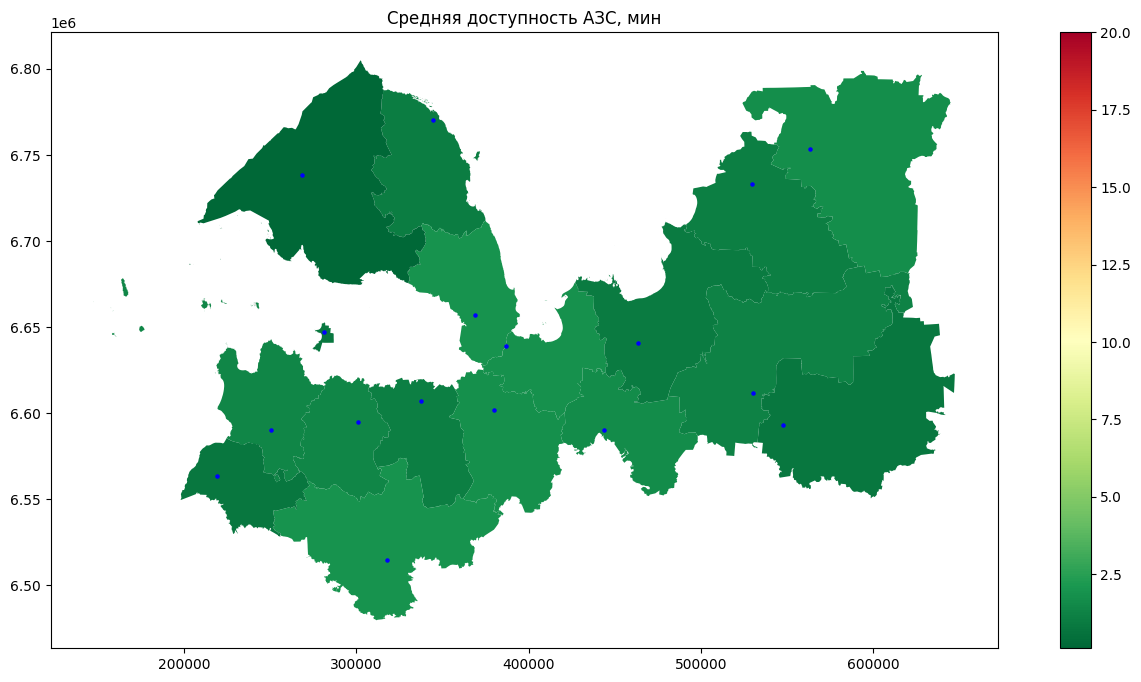

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Отображение полигонов с цветами, зависящими от столбца 'min_distance'
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True, vmax=20)
# Отображение точек
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5)
# Добавление легенды
plt.title('Средняя доступность АЗС, мин')
# Сохранение картинки
plt.savefig('data/png/Средняя доступность АЗС, мин.png', dpi=600)
# Отображение карты
plt.show()

In [195]:
gdf_lines_copy = gdf_lines.copy()
gdf_lines_stops = transferring_points_on_line(stops_gdf, gdf_lines_copy, column_1='NAME', column_2='stops_jd')

In [196]:
# Инициализируйте словарь для хранения сопоставления id дороги и города
road_to_city_mapping = {}

for index, city in admin_centers.iterrows():
    # Создаем буфер вокруг каждого города
    buffer_meter = buffer_for_city[city['admin_centers']]
    buffer = city['geometry'].buffer(buffer_meter)
    roads_in_buffer = gdf_lines_stops.loc[gdf_lines_stops[gdf_lines_stops.geometry.intersects(buffer) & gdf_lines_stops['stops_jd'].notna()].index]
    
    for road_id in roads_in_buffer.index:
        # Если id дороги уже есть в словаре - добавить город к списку городов для этой id
        if road_id in road_to_city_mapping:
            road_to_city_mapping[road_id].append(city['admin_centers'])
        else:  # Если id дороги еще нет в словаре, создайте новый список городов с этим городом
            road_to_city_mapping[road_id] = [city['admin_centers']]
gdf_lines_stops['nearest_stops_jd'] = gdf_lines_stops.index.map(road_to_city_mapping)

In [198]:
gdf_lines_stops['maxspeed'] = gdf_lines_stops['maxspeed'].replace('nan', np.nan)
gdf_lines_stops['maxspeed'] = gdf_lines_stops['maxspeed'].fillna(60)
gdf_lines_stops['time_min'] = (gdf_lines_stops['length_meter'].astype(float)/1000) / (gdf_lines_stops['maxspeed'].astype(float))

In [199]:
graph = momepy.gdf_to_nx(gdf_lines_stops.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_stops_jd'], list):
            if 'nearest_stops_jd' not in graph.nodes[u]:
                graph.nodes[u]['nearest_stops_jd'] = data['nearest_stops_jd']
                

    if graph.nodes[v]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_stops_jd'], list):
            if 'nearest_stops_jd' not in graph.nodes[v]:
                graph.nodes[v]['nearest_stops_jd'] = data['nearest_stops_jd']
    data['length_meter'] = float(data['length_meter'])
    data['time_min'] = float(data['time_min'])

d:\IT\GitHub\ITMO_NCCR\.venv\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [202]:
def search_min_distance_jd(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            source_nodes.append((node, data['admin_centers']))
        if isinstance(data.get('nearest_stops_jd'), list):  # Исходные узлы
            target_nodes.append((node, data['nearest_stops_jd']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            if graph.nodes[target_node].get('nearest_stops_jd') and name in graph.nodes[target_node]['nearest_stops_jd']:
                try: 
                    length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='time_min')
                    if name not in min_distances or (length) < min_distances[name][0]:
                        min_distances[name] = (length, path)
                except nx.NetworkXNoPath:
                    print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length_jd = search_min_distance_jd(graph)

100%|██████████| 16694/16694 [00:35<00:00, 465.00it/s] 


In [203]:
result_path_length_jd[['min_distance']] = result_path_length_jd[['min_distance']] * 60
result_path_length_jd

,min_distance,path
Луга,0.405281,"[(29.845611100002913, 58.734895699996784), (29..."
Волосово,0.624879,"[(29.484855800005366, 59.447896200003946), (29..."
Сосновый бор,1.580098,"[(29.088668700001673, 59.905479899999), (29.09..."
Приозерск,0.420475,"[(30.114542899995076, 61.03676110000151), (30...."
Гатчина,1.024346,"[(30.12230449999694, 59.56906109999617), (30.1..."
Кировск,0.058227,"[(30.980873099996877, 59.874937200002336), (30..."
Всеволожск,2.128479,"[(30.644495000002994, 60.02718920000228), (30...."
Тосно,0.420186,"[(30.87763989999812, 59.54059389999983), (30.8..."
Кириши,1.181851,"[(32.0096432999954, 59.450319400000836), (32.0..."
Волхов,2.033397,"[(32.351664699996086, 59.90337369999849), (32...."


In [24]:
result_path_length_jd.reset_index(inplace=True)
merged = pd.merge(
    gdf_17_points, 
    result_path_length_jd, 
    left_on=['name'], 
    right_on=['index'], 
    how='left'
)

merged_full = pd.merge(
    gdf_polygon[['name', 'geometry']], 
    merged, 
    left_on=['name'], 
    right_on=['municipal district'], 
    how='left'
)

# Преобразование в GeoDataFrame
gdf_merged_full = gpd.GeoDataFrame(merged_full, geometry='geometry_x')

# Установка координатной системы
gdf_merged_full.crs = gdf_polygon.crs

NameError: name 'result_path_length_jd' is not defined

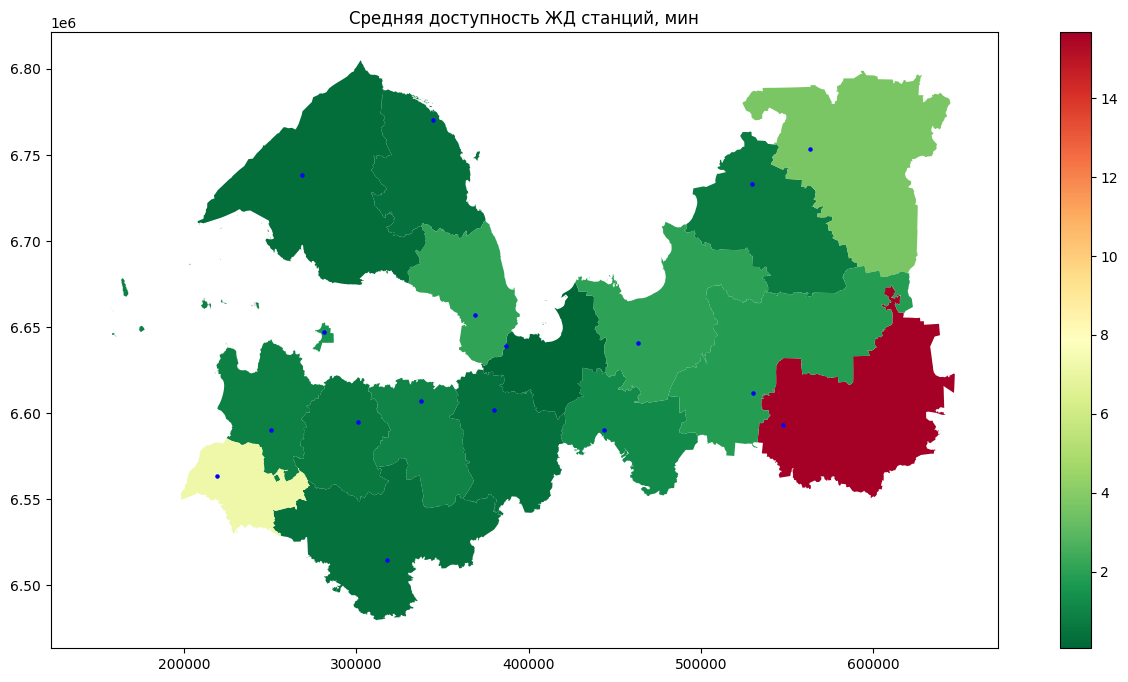

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Отображение полигонов с цветами, зависящими от столбца 'min_distance'
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True)
# Отображение точек
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5)
# Добавление легенды
plt.title('Средняя доступность ЖД станций, мин')
# Сохранение картинки
plt.savefig('data/png/Средняя доступность ЖД станций, мин.png', dpi=600)
# Отображение карты
plt.show()

In [ ]:
import folium
mymap = folium.Map()

edges = [(u,v,d) for u, v, d in graph.edges(data=True)  if isinstance(d['nearest_stops_jd'], list)]
# Отображение на карте
for edge in edges:
    coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                   [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
    folium.PolyLine(coordinates, color="blue", weight=2.5, opacity=1, tooltip=f"{graph.nodes[edge[0]]['nearest_stops_jd']}").add_to(mymap)


for index_city in range(len(result_path_length_jd['path'])):
    for i in range(len(result_path_length_jd['path'][index_city]) - 1):
        edge = (result_path_length_jd['path'][index_city][i], result_path_length_jd['path'][index_city][i+1])
        if i == 0:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                        [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="yellow", weight=2.5, opacity=1).add_to(mymap)
        else:
            coordinates = [[graph.nodes[edge[0]]['y'], graph.nodes[edge[0]]['x']], 
                    [graph.nodes[edge[1]]['y'], graph.nodes[edge[1]]['x']]]
            folium.PolyLine(coordinates, color="red", weight=2.5, opacity=1).add_to(mymap)

mymap

In [ ]:
gdf_lines_stops[gdf_lines_stops['nearest_stops_jd'].notna()]

In [ ]:
result_path_length
result_path_length_18
result_path_length_fuel

In [ ]:
result_path_length_fuel.reset_index()

In [ ]:
relult_regstatus_spb = result_path_length[['min_distance']].reset_index().merge(result_path_length_18[['min_distance']].reset_index(), left_on='index', right_on='index')

In [ ]:
relult_regstatus_spb_fuel = relult_regstatus_spb.merge(result_path_length_fuel[['min_distance, min']].reset_index(), left_on='index', right_on='index')

In [ ]:
relult_regstatus_spb_fuel_jd = relult_regstatus_spb_fuel.merge(result_path_length_jd[['time, min']].reset_index(), left_on='index', right_on='index')

In [ ]:
relult_regstatus_spb_fuel_jd.rename(columns={
    'min_distance_x': 'REG_STATUS, km',
    'min_distance_y': 'SPb, km',
    'min_distance, min': 'time_GAS, min',
    'time, min': 'time_RR, min'
}, inplace=True)
relult_regstatus_spb_fuel_jd.set_index('index', inplace=True)

In [ ]:
relult_regstatus_spb_fuel_jd.to_csv('data/csv/relult_regstatus_spb_gas_rr.csv')

In [11]:
fly_gdf = gpd.read_file('data/geojsons/pulkovo.geojson').to_crs(epsg=32636)
ports_gdf = gpd.read_file('data/geojsons/marine_ports1.geojson').to_crs(epsg=32636)

In [12]:
centroid = fly_gdf.head(1).geometry.centroid
# Создание нового GeoDataFrame с одной строкой, содержащей центроиду
centroid_gdf = gpd.GeoDataFrame(geometry=[centroid.unary_union])
# Добавление колонки 'name' со значением 'Пулково'
centroid_gdf = centroid_gdf.assign(name='Пулково')
# Убедитесь, что CRS (система координат) для centroid_gdf установлена такой же, как и для исходного gdf
centroid_gdf.crs = fly_gdf.crs
# Отображение GeoDataFrame
centroid_gdf.explore()

In [13]:
gdf_18_points = pd.concat([gdf_17_points.to_crs(epsg=32636), centroid_gdf[['name', 'geometry']]], ignore_index=True)
# gdf_lines = transferring_points_on_line(gdf_18_points, roads_within_polygon.drop(columns=['index_right', 'name']), 'name')
gdf_lines_avia = transferring_points_on_line(gdf_18_points, edges, column_1='name', column_2='admin_centers')

In [17]:
gdf_lines_avia['maxspeed'] = gdf_lines_avia['maxspeed'].replace('nan', np.nan)
gdf_lines_avia['maxspeed'] = gdf_lines_avia['maxspeed'].fillna(60)
gdf_lines_avia['time_min'] = (gdf_lines_avia['length_meter'].astype(float)/1000) / (gdf_lines_avia['maxspeed'].astype(float))
gdf_lines_avia[gdf_lines_avia['highway'] == 'living_street']

,length_meter,geometry,type,time_min,highway,maxspeed,node_start,node_end,admin_centers
2426,113.77300525897519,"LINESTRING (315987.666 6513728.658, 316021.032...",car,0.001896,living_street,60,867,965,NaN
2641,113.77300525897519,"LINESTRING (316094.019 6513768.732, 316021.032...",car,0.001896,living_street,60,965,867,NaN
2642,163.50094376330003,"LINESTRING (316094.019 6513768.732, 316058.936...",car,0.002725,living_street,60,965,966,NaN
2643,187.8367693103557,"LINESTRING (316094.019 6513768.732, 316139.784...",car,0.003131,living_street,60,965,967,NaN
2644,196.19167973705146,"LINESTRING (316019.930 6513914.287, 315949.921...",car,0.003270,living_street,60,966,969,NaN
...,...,...,...,...,...,...,...,...,...
276792,252.1514315110223,"LINESTRING (256742.660 6738269.314, 256744.389...",car,0.004203,living_street,60,110619,110135,NaN
276793,274.32732690666364,"LINESTRING (256742.660 6738269.314, 256716.971...",car,0.004572,living_street,60,110619,110135,NaN
276794,341.664712547177,"LINESTRING (256742.660 6738269.314, 256776.623...",car,0.005694,living_street,60,110619,110129,NaN
277990,151.35986135521586,"LINESTRING (259043.388 6724128.849, 259123.592...",car,0.002523,living_street,60,111177,109557,NaN


In [18]:
graph = momepy.gdf_to_nx(gdf_lines_avia.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
                
    if graph.nodes[v]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
    data['length_meter'] = float(data['length_meter'])
    data['time_min'] = float(data['time_min'])

def search_min_distance_avia(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            if data['admin_centers'] != 'Пулково':
                source_nodes.append((node, data['admin_centers']))
            elif data['admin_centers'] == 'Пулково':  # Целевые узлы
                target_nodes.append((node, data['admin_centers']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            try: 
                length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='time_min')
                if name not in min_distances or (length) < min_distances[name][0]:
                    min_distances[name] = (length, path)
            except nx.NetworkXNoPath:
                print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length_avia = search_min_distance_avia(graph)

e:\Roman\GitHub\ITMO_NCCR\.venv\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


In [25]:
# Объединение DataFrame
result_path_length_avia.reset_index(inplace=True)
merged = pd.merge(
    gdf_18_points, 
    result_path_length_avia, 
    left_on=['name'], 
    right_on=['index'], 
    how='left'
)

merged_full = pd.merge(
    gdf_polygon[['name', 'geometry']], 
    merged, 
    left_on=['name'], 
    right_on=['municipal district'], 
    how='left'
)

# Преобразование в GeoDataFrame
gdf_merged_full = gpd.GeoDataFrame(merged_full, geometry='geometry_x')

# Установка координатной системы
gdf_merged_full.crs = gdf_polygon.crs

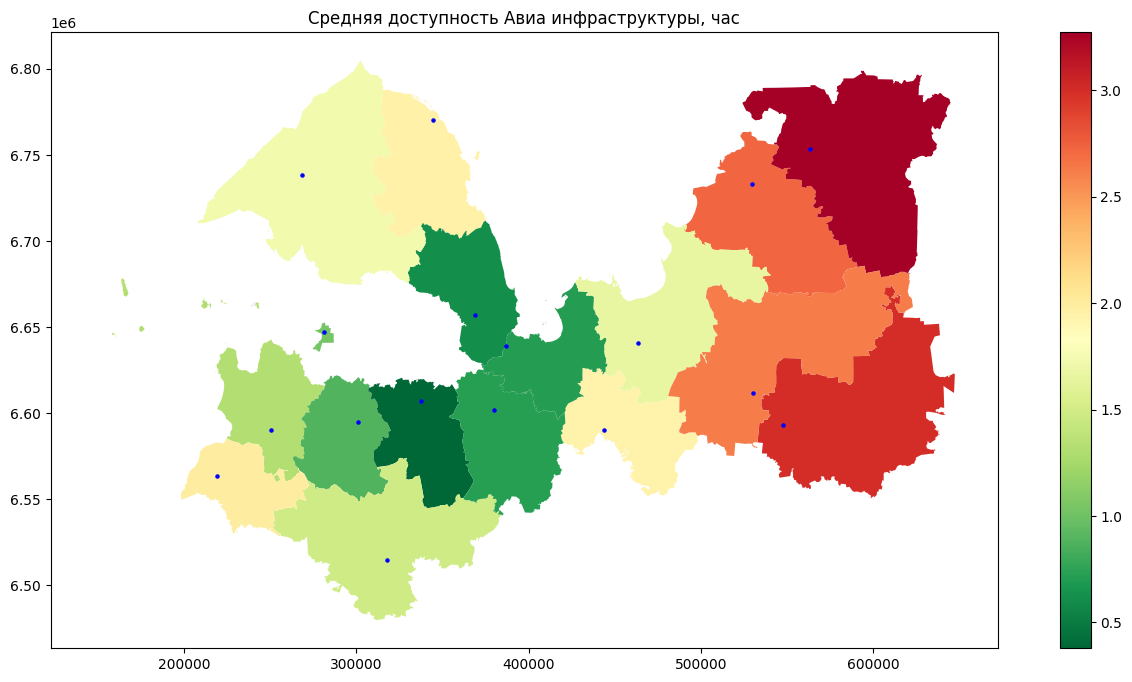

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Отображение полигонов с цветами, зависящими от столбца 'min_distance'
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True)
# Отображение точек
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5)
# Добавление легенды
plt.title('Средняя доступность Авиа инфраструктуры, час')
# Сохранение картинки
plt.savefig('data/png/Средняя доступность Авиа инфраструктуры, час.png', dpi=600)
# Отображение карты
plt.show()

In [228]:
ports_gdf['geometry'] = ports_gdf.geometry.centroid

In [229]:
ports_gdf

,id,@id,cargo,industrial,landuse,name,port,port:type,type,url,...,height,source,was:amenity,entrance,drive_through,post_box:design,post_box:type,seamark:mooring:category,seamark:type,geometry
0,relation/3846263,relation/3846263,None,port,industrial,порт Выборг,cargo,None,multipolygon,None,...,None,None,None,None,None,None,None,None,None,POINT (267316.261 6737718.823)
1,relation/9374437,relation/9374437,None,port,industrial,Перегруз щебня,None,None,multipolygon,None,...,None,None,None,None,None,None,None,None,None,POINT (332851.096 6782649.740)
2,way/704134882,way/704134882,None,port,industrial,Морской фасад,passenger,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (343042.274 6648944.177)
3,way/843234873,way/843234873,None,port,industrial,Lugaport,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (243696.282 6630528.626)


In [230]:
gdf_lines_copy = gdf_lines.copy()
gdf_lines_ports = transferring_points_on_line(ports_gdf, gdf_lines_copy, column_1='name', column_2='ports')

In [231]:
buffer_for_city = {
    'Луга':             2000000,
    'Волосово':         2000000,
    'Сосновый бор':     2000000,
    'Приозерск':        2000000,
    'Гатчина':          2000000,
    'Кировск':          2000000,
    'Всеволожск':       2000000,
    'Тосно':            2000000,
    'Кириши':           2000000,
    'Волхов':           2000000,
    'Лодейное Поле':    2000000,
    'Тихвин':           2000000,
    'Бокситогорск':     4000000,
    'Подпорожье':       2000000,
    'Кингисепп':        2000000,
    'Выборг':           2000000,
    'Сланцы':           2000000
}

In [232]:
# Инициализируйте словарь для хранения сопоставления id дороги и города
road_to_city_mapping = {}

for index, city in admin_centers.iterrows():
    # Создаем буфер вокруг каждого города
    buffer_meter = buffer_for_city[city['admin_centers']]
    buffer = city['geometry'].buffer(buffer_meter)
    roads_in_buffer = gdf_lines_ports.loc[gdf_lines_ports[gdf_lines_ports.geometry.intersects(buffer) & gdf_lines_ports['ports'].notna()].index]
    
    for road_id in roads_in_buffer.index:
        # Если id дороги уже есть в словаре - добавить город к списку городов для этой id
        if road_id in road_to_city_mapping:
            road_to_city_mapping[road_id].append(city['admin_centers'])
        else:  # Если id дороги еще нет в словаре, создайте новый список городов с этим городом
            road_to_city_mapping[road_id] = [city['admin_centers']]
gdf_lines_ports['nearest_ports'] = gdf_lines_ports.index.map(road_to_city_mapping)

In [233]:
gdf_lines_ports['maxspeed'] = gdf_lines_ports['maxspeed'].replace('nan', np.nan)
gdf_lines_ports['maxspeed'] = gdf_lines_ports['maxspeed'].fillna(60)
gdf_lines_ports['time_min'] = (gdf_lines_ports['length_meter'].astype(float)/1000) / (gdf_lines_ports['maxspeed'].astype(float))

In [234]:
graph = momepy.gdf_to_nx(gdf_lines_ports.to_crs(epsg=4326))
for node in graph.nodes:
    graph.nodes()[node]['x'] = node[0]
    graph.nodes()[node]['y'] = node[1]

# Для каждого ребра в графе
for u, v, data in graph.edges(data=True):
    if graph.nodes[u]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[u]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_ports'], list):
            if 'nearest_ports' not in graph.nodes[u]:
                graph.nodes[u]['nearest_ports'] = data['nearest_ports']
                

    if graph.nodes[v]:
        if isinstance(data['admin_centers'], str):
            graph.nodes[v]['admin_centers'] = data['admin_centers']
        if isinstance(data['nearest_ports'], list):
            if 'nearest_ports' not in graph.nodes[v]:
                graph.nodes[v]['nearest_ports'] = data['nearest_ports']
    data['length_meter'] = float(data['length_meter'])
    data['time_min'] = float(data['time_min'])

d:\IT\GitHub\ITMO_NCCR\.venv\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [235]:
def search_min_distance_ports(graph):
    source_nodes = []
    target_nodes = []

    # Формируем список исходных и целевых узлов
    for node, data in graph.nodes(data=True):
        if isinstance(data.get('admin_centers'), str):  # Исходные узлы
            source_nodes.append((node, data['admin_centers']))
        if isinstance(data.get('nearest_ports'), list):  # Исходные узлы
            target_nodes.append((node, data['nearest_ports']))

    min_distances = {} # Словарь для хранения минимальных расстояний

    # Общее количество итераций для отображения прогресса
    total_iterations = len(source_nodes) * len(target_nodes)

    progress_bar = tqdm(total=total_iterations)  # Инициализация индикатора прогресса

    # Поиск кратчайшего пути и запоминание минимального расстояния
    for source_node, name in source_nodes:
        for target_node, name_right in target_nodes:
            if graph.nodes[target_node].get('nearest_ports') and name in graph.nodes[target_node]['nearest_ports']:
                try: 
                    length, path = nx.single_source_dijkstra(graph, source=source_node, target=target_node, weight='time_min')
                    if name not in min_distances or (length) < min_distances[name][0]:
                        min_distances[name] = (length, path)
                except nx.NetworkXNoPath:
                    print(f"Путь до {name_right} не найден.")
            progress_bar.update()  # Обновление индикатора прогресса

    progress_bar.close()  # Закрытие индикатора прогресса

    # Преобразование словаря в DataFrame для более удобного отображения
    df = pd.DataFrame(min_distances.values(), index=min_distances.keys())
    df.columns = ['min_distance', 'path']
    return df

result_path_length_ports = search_min_distance_ports(graph)

100%|██████████| 272/272 [06:09<00:00,  1.36s/it]


In [236]:
result_path_length_ports.reset_index(inplace=True)
merged = pd.merge(
    gdf_18_points, 
    result_path_length_ports, 
    left_on=['name'], 
    right_on=['index'], 
    how='left'
)

merged_full = pd.merge(
    gdf_polygon[['name', 'geometry']], 
    merged, 
    left_on=['name'], 
    right_on=['municipal district'], 
    how='left'
)

# Преобразование в GeoDataFrame
gdf_merged_full = gpd.GeoDataFrame(merged_full, geometry='geometry_x')

# Установка координатной системы
gdf_merged_full.crs = gdf_polygon.crs

AttributeError: PathCollection.set() got an unexpected keyword argument 'title'

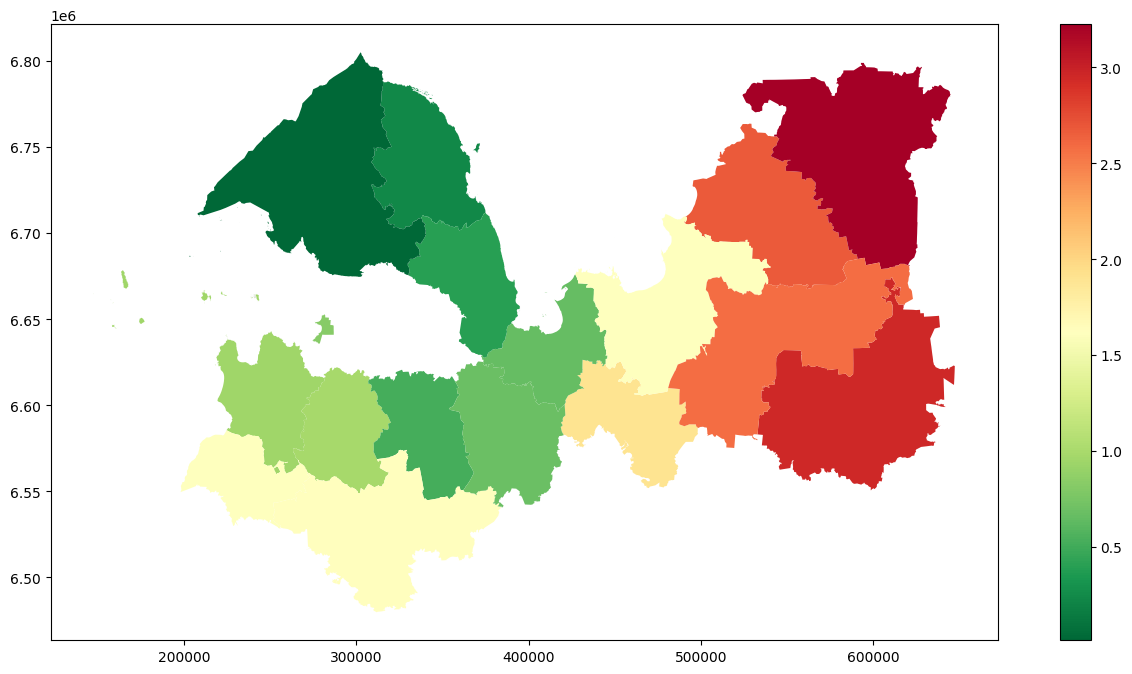

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Отображение полигонов с цветами, зависящими от столбца 'min_distance'
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True)
# Отображение точек
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5, title='Админ. центры')
ports_gdf.geometry.plot(ax=ax, color='red', markersize=7, title='Порты')
# Добавление легенды
plt.title('Cредняя доступность объектов водного транспорта, час')
# Сохранение картинки
plt.savefig('data/png/Cредняя доступность объектов водного транспорта, час.png', dpi=600)
# Отображение карты
plt.show()

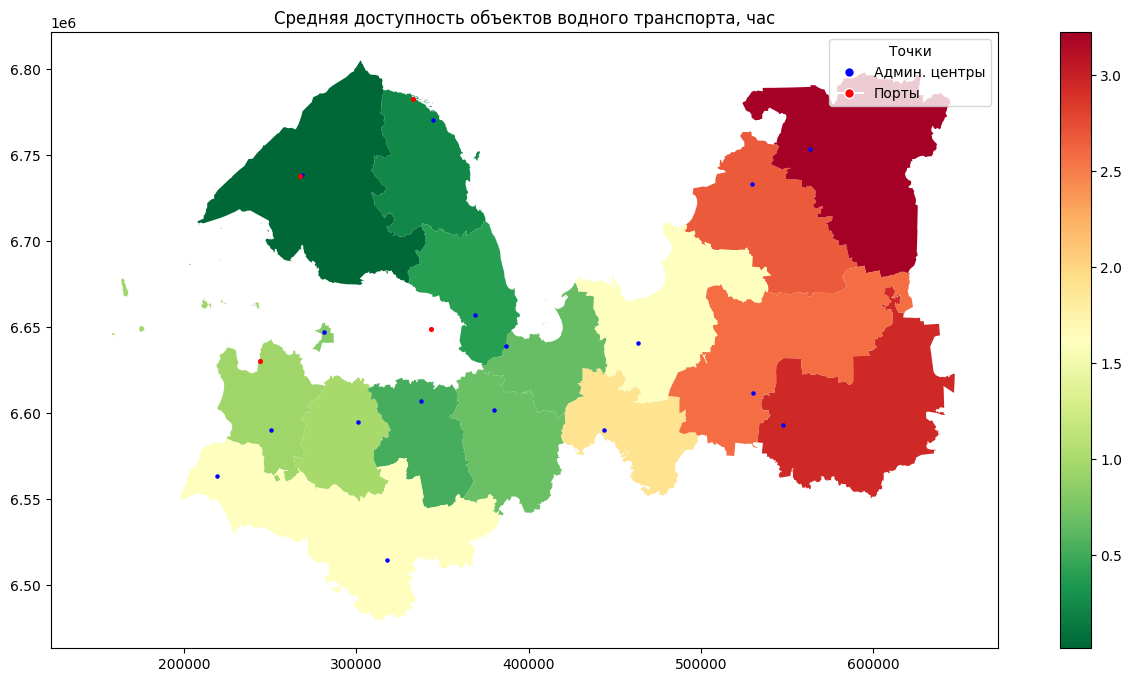

In [239]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
gdf_merged_full.to_crs(epsg=32636).plot(column='min_distance', cmap='RdYlGn_r', ax=ax, legend=True)
gdf_merged_full.geometry_y.plot(ax=ax, color='blue', markersize=5, label='Админ. центры')
ports_gdf.geometry.plot(ax=ax, color='red', markersize=7, label='Порты')
custom_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label='Админ. центры'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='Порты')]
ax.legend(handles=custom_legend, title='Точки')
plt.title('Cредняя доступность объектов водного транспорта, час')
plt.savefig('data/png/Cредняя доступность объектов водного транспорта, час.png', dpi=600)
plt.show()

In [240]:
ports_gdf.geometry.explore()